In [6]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

spectral_source ='Capella'

calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

min_distance = 10  # Adjust as needed
prominence = 1e4  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df = pd.read_csv(output_file_name_cropped_data)

#print(df)

output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df_spectra = pd.read_csv(output_file_name_cropped_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df_dips = pd.read_csv(output_file_name_dips_data)

weight_file = 'sensor-weight-data.csv'
df_weights = pd.read_csv(weight_file)


optimal_shifts = df_dips['Optimal Shift'].values

# Create bins
bin_width = 1
bins = np.arange(3000, 7500+bin_width, bin_width)  # Adjust bin width as needed5
#print(bins)
global_bins = np.zeros(len(bins) - 1)
global_intensity_sum = np.zeros(len(bins) - 1)
bin_intensity_values = [[] for _ in range(len(bins) - 1)]

def resample_weights(wavelength_range_vega, weight_vega, bins):
	interp_func = interp1d(wavelength_range_vega, weight_vega, kind='linear', fill_value='extrapolate')

	weights_resampled = interp_func(bins)
	
	return weights_resampled


for index, row in df_spectra.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	new_intensity_values_along_y = new_intensity_values_along_y * 3 * 1e6 / np.max(new_intensity_values_along_y)
	
	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	spec_shift = optimal_shifts[index]
	calibrated_wavelengths = calibrated_wavelengths + spec_shift
	
	weights_source = resample_weights(df_weights['Wavelength(A)'], df_weights['Weight'], calibrated_wavelengths)

	bin_indices = np.digitize(calibrated_wavelengths, bins, right=True)

	for i, bin_index in enumerate(bin_indices):
		if bin_index > 0 and bin_index < len(bins):
			global_bins[bin_index - 1] += 1
			global_intensity_sum[bin_index - 1] += new_intensity_values_along_y[i]*weights_source[i]
			bin_intensity_values[bin_index - 1].append(new_intensity_values_along_y[i]*weights_source[i])

	#print(global_bins)
	# if index == 0:
	# 	plt.figure(figsize=(10, 6))
	# 	plt.plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated Spectrum')
	# 	plt.plot([calibrated_wavelengths[pixel_position] for pixel_position in dips], [new_intensity_values_along_y[pixel_position] for pixel_position in dips], 'ro', markersize=5, label='Detected Dips')
	# 	plt.xlabel('Wavelength (nm)')
	# 	plt.ylabel('Intensity')
	# 	plt.title('Star Spectrum with Detected Dips (Absorption Features)')
	# 	plt.legend()
	# 	plt.grid(True)
	# 	plt.show()
	# 	plt.close()

	# 	print(index)
	# 	print('Detected Dips (Absorption Features):')
	# 	for pixel_position, wavelength in dips_wavelengths.items():
	# 		print(f'Pixel Position: {pixel_position}, Wavelength: {wavelength} nm')
	# 	print()

# Print counts for each bin
# print("Global Bin Counts:")
# print(global_bins)
# print(global_intensity_sum/global_bins)

bin_std_dev = [np.std(values) for values in bin_intensity_values]
bin_std_dev = np.array(bin_std_dev)

bins = bins[:-1] + bin_width
global_mean_intensity = global_intensity_sum / global_bins
global_mean_intensity = np.nan_to_num(global_mean_intensity, nan=0, posinf=0, neginf=0)
non_zero_mask = global_mean_intensity != 0
global_mean_intensity = global_mean_intensity[non_zero_mask]
bins = bins[non_zero_mask]

bin_std_dev = bin_std_dev[non_zero_mask]
smooth = savgol_filter(global_mean_intensity, window_length=30, polyorder=5)
dips, _ = find_peaks(-smooth, distance=min_distance, prominence=prominence)
dips_wavelengths = {pixel_position: bins[pixel_position] for pixel_position in dips}

C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\USER\AppData\Local\Temp\ipykernel_18484\2915527121.py:102: RuntimeWarning: invalid value encountered in divide
  global_mean_intensity = global_intensity_sum / global_bins


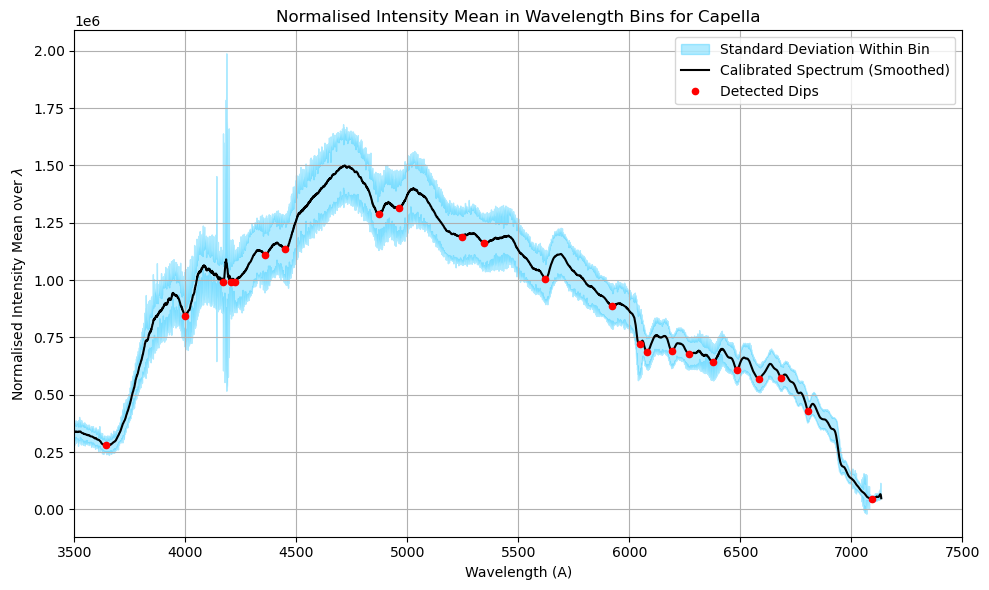

In [7]:
#STUPIDER
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.3, label='Standard Deviation Within Bin')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='black', label='Calibrated Spectrum (Smoothed)')
plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title(f'Normalised Intensity Mean in Wavelength Bins for {stellar_source}')
plt.xlim(3500,7500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Define a function to identify and analyze absorption lines
def identify_absorption_lines(wavelengths, intensities, dips):
    absorption_lines = {}

    for dip_position in dips:
        # Extract a small window around the dip for analysis
        window_size = 10
        start_index = max(0, dip_position - window_size // 2)
        end_index = min(len(wavelengths), dip_position + window_size // 2)

        # Extract data within the window
        window_wavelengths = wavelengths[start_index:end_index]
        window_intensities = intensities[start_index:end_index]

        # Identify the minimum point within the window as the dip
        min_intensity_index = np.argmin(window_intensities)
        dip_wavelength = window_wavelengths[min_intensity_index]
        dip_intensity = window_intensities[min_intensity_index]

        # Store the identified absorption line
        absorption_lines[dip_wavelength] = dip_intensity

    return absorption_lines

# Identify absorption lines in the global spectrum
global_absorption_lines = identify_absorption_lines(bins, smooth, dips)

# Print identified absorption lines (wavelength and intensity)
print("Identified Absorption Lines:")
for wavelength, intensity in global_absorption_lines.items():
    print(f"Wavelength: {wavelength:.2f} A, Intensity: {intensity:.2f}")


# Read element mapping from the text file
element_mapping_file = 'C:/Users/USER/desktop/Spectroscope/Vega/element_wavelengths.txt'  # Replace with your file path
with open(element_mapping_file, 'r') as file:
    element_mapping_lines = file.readlines()

# Parse element mapping lines
element_mapping = {}
for line in element_mapping_lines:
    parts = line.split()
    element_name = parts[0]
    line_name = parts[1]
    line_wavelength = float(parts[2])
    element_mapping[line_wavelength] = (element_name, line_name)

# Identify elements based on wavelength
identified_elements = {}
for wavelength, intensity in global_absorption_lines.items():
    for line_wavelength, (element, line_name) in element_mapping.items():
        tolerance = 90.0  # Adjust as needed
        if abs(wavelength - line_wavelength) < tolerance:
            identified_elements[f"{element} {line_name}"] = intensity

# Print identified elements and their intensities
print("\nIdentified Elements and Intensities:")
for element, intensity in identified_elements.items():
    print(f"{element}: {intensity:.2f}")

# Continue with further analysis or output results as needed


Identified Absorption Lines:
Wavelength: 3469.00 A, Intensity: 312253.02
Wavelength: 3645.00 A, Intensity: 279108.82
Wavelength: 4001.00 A, Intensity: 842610.75
Wavelength: 4169.00 A, Intensity: 991008.62
Wavelength: 4205.00 A, Intensity: 992766.19
Wavelength: 4226.00 A, Intensity: 989743.66
Wavelength: 4360.00 A, Intensity: 1108916.60
Wavelength: 4448.00 A, Intensity: 1134521.11
Wavelength: 4871.00 A, Intensity: 1287402.25
Wavelength: 4961.00 A, Intensity: 1312481.73
Wavelength: 5248.00 A, Intensity: 1189765.64
Wavelength: 5347.00 A, Intensity: 1161781.47
Wavelength: 5620.00 A, Intensity: 1006020.58
Wavelength: 5922.00 A, Intensity: 885456.64
Wavelength: 6047.00 A, Intensity: 720513.34
Wavelength: 6080.00 A, Intensity: 686684.19
Wavelength: 6193.00 A, Intensity: 689364.77
Wavelength: 6271.00 A, Intensity: 678711.97
Wavelength: 6378.00 A, Intensity: 641290.74
Wavelength: 6484.00 A, Intensity: 608679.82
Wavelength: 6586.00 A, Intensity: 570519.74
Wavelength: 6684.00 A, Intensity: 574677

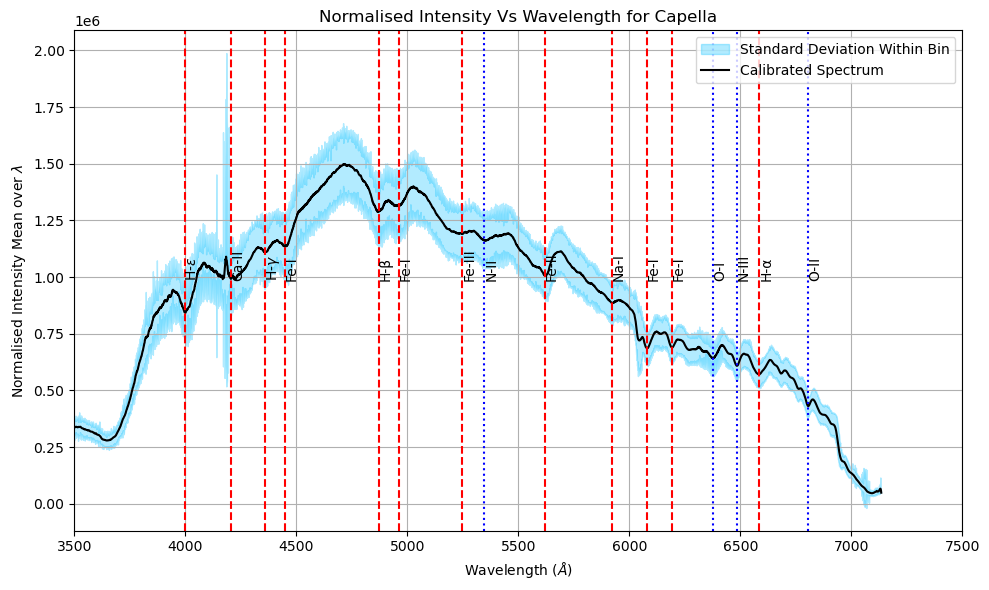

In [53]:
#STUPIDER
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.3, label='Standard Deviation Within Bin')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='black', label='Calibrated Spectrum ')
#plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title(f'Normalised Intensity Vs Wavelength for {stellar_source}')
plt.xlim(3500, 7500)
plt.legend()
plt.grid(True)

# Add labels for the lines
h_alpha_wavelength = 6586  
plt.axvline(x=h_alpha_wavelength, color='r', linestyle='--', label='H-$\alpha$ ')
plt.text(h_alpha_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-α', rotation=90, verticalalignment='bottom')

h_beta_wavelength = 4871
plt.axvline(x=h_beta_wavelength, color='r', linestyle='--', label= 'H-$\beta$')
plt.text(h_beta_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-β', rotation=90, verticalalignment='bottom')

fe11_wavelength = 4448 
plt.axvline(x=fe11_wavelength, color='r', linestyle='--', label='Fe-I')
plt.text(fe11_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Fe-I', rotation=90, verticalalignment='bottom')

fe12_wavelength = 6193 
plt.axvline(x=fe12_wavelength, color='r', linestyle='--', label='Fe-I')
plt.text(fe12_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Fe-I', rotation=90, verticalalignment='bottom')

fe13_wavelength = 6080 
plt.axvline(x=fe13_wavelength, color='r', linestyle='--', label='Fe-I')
plt.text(fe13_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Fe-I', rotation=90, verticalalignment='bottom')

fe2_wavelength = 5620 
plt.axvline(x=fe2_wavelength, color='r', linestyle='--', label='Fe-II')
plt.text(fe2_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Fe-II', rotation=90, verticalalignment='bottom')

fe1_wavelength = 4961  
plt.axvline(x=fe1_wavelength, color='r', linestyle='--', label='Fe-I')
plt.text(fe1_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Fe-I', rotation=90, verticalalignment='bottom')

fe3_wavelength = 5248  
plt.axvline(x=fe3_wavelength, color='r', linestyle='--', label='Fe-III')
plt.text(fe3_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Fe-III', rotation=90, verticalalignment='bottom')


o2_wavelength = 6806  
plt.axvline(x=o2_wavelength, color='b', linestyle=':', label='O-II')
plt.text(o2_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'O-II', rotation=90, verticalalignment='bottom')

ca_wavelength = 4205  
plt.axvline(x=ca_wavelength, color='r', linestyle='--', label='Ca-II')
plt.text(ca_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Ca-II', rotation=90, verticalalignment='bottom')

h_epsilon_wavelength = 4001  
plt.axvline(x=h_epsilon_wavelength, color='r', linestyle='--', label='H-$\epsilon$')
plt.text(h_epsilon_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-$\epsilon$', rotation=90, verticalalignment='bottom')


o1_wavelength = 6378 
plt.axvline(x=o1_wavelength, color='b', linestyle=':', label='O-I')
plt.text(o1_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'O-I', rotation=90, verticalalignment='bottom')


h_gamma_wavelength = 4360  
plt.axvline(x=h_gamma_wavelength, color='r', linestyle='--', label='H-$\gamma$')
plt.text(h_gamma_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-$\gamma$', rotation=90, verticalalignment='bottom')

n3_wavelength = 6484
plt.axvline(x=n3_wavelength, color='b', linestyle=':', label='N-III')
plt.text(n3_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'N-III', rotation=90, verticalalignment='bottom')

n2_wavelength = 5347
plt.axvline(x=n2_wavelength, color='b', linestyle=':', label='N-II')
plt.text(n2_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'N-II', rotation=90, verticalalignment='bottom')


na_wavelength = 5922 
plt.axvline(x=na_wavelength, color='r', linestyle='--', label='Na-I')
plt.text(na_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'Na-I', rotation=90, verticalalignment='bottom')


plt.tight_layout()
plt.savefig('Capella Spectrum.png')
plt.show()

